# Simple EDA and Feature Preprocessing

### No null values, lot of categorical feature, might have to drop a few features like 'date'.
### It is an imbalanced dataset i.e a lot more no. of 'No' than 'Yes' outcomes... 29809 vs 1840, have to look at different ways to deal with this.

In [18]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import Imputer
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder


In [6]:
dataset = pd.read_csv('Yes_Bank_Training.csv')
test = pd.read_csv('Yes_Bank_Test.csv')

print(dataset.describe())
print(dataset.head())


       serial_number  age_in_years  balance_in_account          date  \
count   31649.000000  31649.000000        31649.000000  31649.000000   
mean    15825.000000     41.111820         1293.382540     16.597997   
std      9136.423671      9.597652         2961.185138      8.586414   
min         1.000000     19.000000        -8019.000000      1.000000   
25%      7913.000000     33.000000           47.000000      9.000000   
50%     15825.000000     40.000000          397.000000     18.000000   
75%     23737.000000     49.000000         1328.000000     23.000000   
max     31649.000000     94.000000        98417.000000     31.000000   

       call_duration  campaign_contacts   days_passed  previous_contact  
count   31649.000000       31649.000000  31649.000000      31649.000000  
mean      252.408196           3.062372     10.819931          0.208537  
std       262.344981           3.510245     48.086849          1.946336  
min         0.000000           1.000000     -1.000000  

In [7]:
print(dataset.isnull().sum())


serial_number           0
age_in_years            0
job_description         0
marital_status          0
education_details       0
has_default             0
balance_in_account      0
housing_status          0
previous_loan           0
phone_type              0
date                    0
month_of_year           0
call_duration           0
campaign_contacts       0
days_passed             0
previous_contact        0
poutcome_of_campaign    0
outcome                 0
dtype: int64


## Gives count of few Categorical features

In [26]:
print(dataset["job_description"].value_counts())
print(dataset["education_details"].value_counts())
print(dataset["phone_type"].value_counts())
#dataset["outcome_of_the_campaign"].value_counts()
print(dataset["outcome"].value_counts())


blue-collar      6948
management       6705
technician       5684
admin.           3354
services         2965
retired          1232
self-employed    1164
entrepreneur     1160
housemaid         969
unemployed        950
student           297
unknown           221
Name: job_description, dtype: int64
secondary    16303
tertiary      9097
primary       4977
unknown       1272
Name: education_details, dtype: int64
cellular     17181
unknown      12765
telephone     1703
Name: phone_type, dtype: int64
0    29809
1     1840
Name: outcome, dtype: int64


### Encodes target varible- yes/no to 1/0

In [20]:
from sklearn.preprocessing import LabelEncoder
encoder= LabelEncoder()
dataset_cat= dataset["outcome"]
dataset_encoded= encoder.fit_transform(dataset_cat)
dataset_encoded
dataset['outcome']=dataset_encoded


## Got to visualize more plots with different variables to deal with outliers, useless features etc..

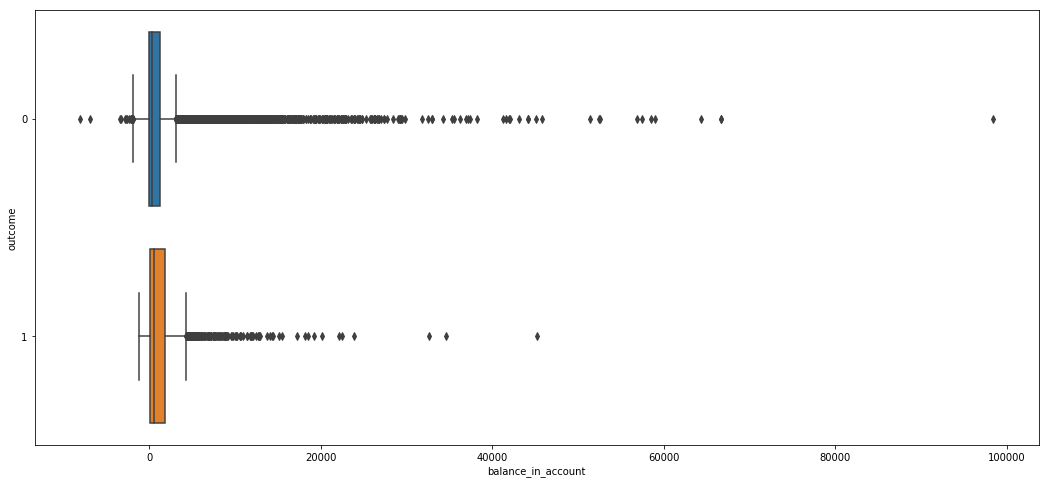

In [21]:
X = dataset.drop(['serial_number'], axis=1)
y=dataset['outcome']
X_test = test.drop(['serial_number'], axis=1)
_, axes = plt.subplots(sharey=True, figsize=(18, 8))

sns.boxplot(x=X['balance_in_account'], y=y, orient='h');


### Encodes binary categorical varables

In [22]:
le = LabelEncoder()
le_count = 0

# Iterate through the columns
for col in X:
    if X[col].dtype == 'object':
        # If 2 or fewer unique categories
        if len(list(X[col].unique())) <= 2:
            # Train on the training data
            le.fit(X[col])
            # Transform both training and testing data
            X[col] = le.transform(X[col])
            X_test[col] = le.transform(X_test[col])
            
            # Keep track of how many columns were label encoded
            le_count += 1
            
print('%d columns were label encoded.' % le_count)


3 columns were label encoded.


### One hot encoding categoric variables

In [23]:
X = pd.get_dummies(X)#One hot encoding(Prolly better ways of doing this)
X_test = pd.get_dummies(X_test)

train_labels = X['outcome']
# Align the training and testing data, keep only columns present in both dataframes
X, X_test = X.align(X_test, join = 'inner', axis = 1)

# Add the target back in
X['outcome'] = train_labels

print('Training Features shape: ', X.shape)
print('Testing Features shape: ', X_test.shape)



Training Features shape:  (31649, 48)
Testing Features shape:  (13562, 47)


### Correlations, gotta read up more on this...

In [24]:
correlations = X.corr()['outcome'].sort_values()
# Display correlations
print('Most Positive Correlations:\n', correlations.tail(15))
print('\nMost Negative Correlations:\n', correlations.head(15))


Most Positive Correlations:
 phone_type_telephone            0.016152
month_of_year_apr               0.017399
job_description_retired         0.019110
job_description_student         0.020633
marital_status_divorced         0.023322
balance_in_account              0.025711
poutcome_of_campaign_success    0.027502
education_details_tertiary      0.036436
marital_status_single           0.040299
phone_type_cellular             0.059126
month_of_year_feb               0.063255
month_of_year_oct               0.119257
month_of_year_mar               0.165181
call_duration                   0.476821
outcome                         1.000000
Name: outcome, dtype: float64

Most Negative Correlations:
 phone_type_unknown             -0.067470
month_of_year_may              -0.063681
marital_status_married         -0.051935
housing_status                 -0.038693
campaign_contacts              -0.023763
previous_loan                  -0.023491
month_of_year_jun              -0.023153
month_of_

# MODEL TRAINING

### Random Forest Regressor giving 94% acccuracy xD Overfitting?
### Got to try out other cross validation techniques...

In [25]:
X_train=X.drop(['outcome'], axis=1)
y=X['outcome']

from sklearn.model_selection import train_test_split
X_train_final, X_val, y_train, y_val = train_test_split(X_train, y, test_size = 0.25,  shuffle=True, random_state = 0)

regressor = RandomForestClassifier(random_state = 0)
regressor.fit(X_train_final, y_train)
y_pred = regressor.predict(X_val)
print(accuracy_score(y_pred, y_val))
print("Mean Absolute Error from Imputation while Track What Was Imputed:")


C:\Users\Niranjan\Anaconda3\lib\site-packages\sklearn\ensemble\forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


0.9449007961582206
Mean Absolute Error from Imputation while Track What Was Imputed:


# Things to try out on top of my head
### K- fold cross validation
### More EDA and feature processing, plots, polynomial features, try to make additional features
### Ensembling, hyperparameter tuning, choosing the right model...